<a href="https://colab.research.google.com/github/parseny/Generative-Models-2024/blob/main/Assignment%202/DCGAN/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST, CIFAR10
from IPython.display import Image
from torchvision.utils import save_image
import os
%matplotlib inline
plt.style.use("ggplot")

class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "/home/jupyter/datasphere/project/Generative-Models-2024/Assignment 2/data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

In [2]:
cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

100%|██████████| 170498071/170498071 [00:09<00:00, 17313609.57it/s]


Extracting data/cifar-10-python.tar.gz to data


Label:  6


(array([ 163.,  666., 1355., 1486., 1462., 1072.,  979.,  795.,  760.,
         774., 1138.,  700.,  411.,  308.,  219.]),
 array([-0.73333335, -0.61777776, -0.50222224, -0.38666669, -0.27111113,
        -0.15555556, -0.04000001,  0.07555555,  0.1911111 ,  0.30666667,
         0.42222223,  0.53777778,  0.65333331,  0.76888889,  0.88444442,
         1.        ]),
 <BarContainer object of 15 artists>)

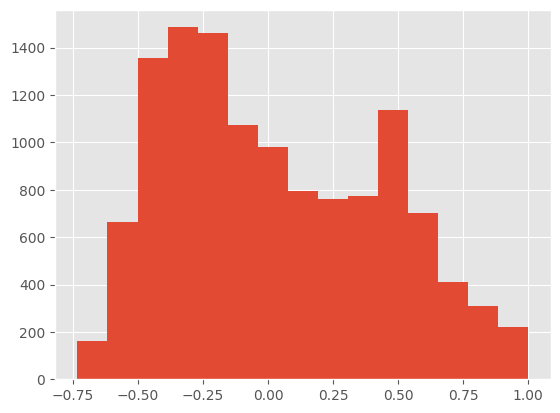

In [3]:
img, label = cifar_dataset[25]
print("Label: ", label)
plt.hist(img[:, :, :].flatten(), bins=15)

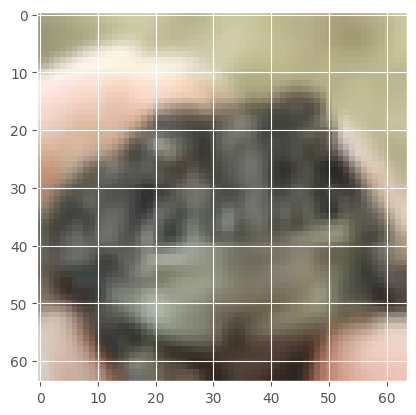

In [4]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
def denorm(img):
    return (img + 1) / 2

# show  image sample with matplotlib
imgplot = plt.imshow(denorm(img.permute(1, 2, 0)))

In [6]:
# define the dataloader
from torch.utils.data import DataLoader

dataloader = DataLoader(cifar_dataset, batch_size=CFG.batch_size, shuffle=True)
# for i, (images, _) in enumerate(dataloader):
#   print(i, images.shape)
#   imgplot = plt.imshow(denorm(images[-1].permute(1, 2, 0)))

# Just DCGAN

## Technic setup

In [56]:
import torch.nn as nn
# Generator
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super(Generator, self).__init__()
        self.sequential = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 16, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # Second ConvTranspose2d: from ngf*8 to ngf*4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # Third ConvTranspose2d: from ngf*4 to ngf*2
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # Fourth ConvTranspose2d: from ngf*2 to ngf
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # Final ConvTranspose2d: from ngf to nc (output channels)
            nn.ConvTranspose2d(ngf, nc, kernel_size=3, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        x = input.view(input.shape[0], input.shape[1], 1, 1)
        x = self.sequential(x)
        return x

# Discriminator

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.sequential = nn.Sequential(
            # Первый слой: от (nc, 64, 64) до (ndf, 32, 32), без BatchNorm и Dropout
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # Второй слой: от (ndf, 32, 32) до (ndf*2, 16, 16) с BatchNorm и Dropout
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),

            # Третий слой: от (ndf*2, 16, 16) до (ndf*4, 8, 8) с BatchNorm и Dropout
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),

            # Четвертый слой: от (ndf*4, 8, 8) до (ndf*8, 4, 4) с BatchNorm и Dropout
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),

            # Пятый слой: от (ndf*8, 4, 4) до (1, 1, 1) с Sigmoid для классификации
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.sequential(x)
        return x.view(x.size(0), -1)
    

def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0) 

In [57]:
np.random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(CFG.seed)
    torch.cuda.manual_seed_all(CFG.seed)

In [195]:
# create new Generator model
G = Generator(CFG.nc, CFG.nz, CFG.ngf)

# create new Discriminator model
D = Discriminator(CFG.nc, CFG.ndf)

initialize_weights(G)
initialize_weights(D)

# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator
optimizer_G = torch.optim.Adam(G.parameters(), lr=CFG.lr*1.25, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=CFG.lr, betas=(0.5, 0.999))

torch.Size([2, 3, 64, 64])


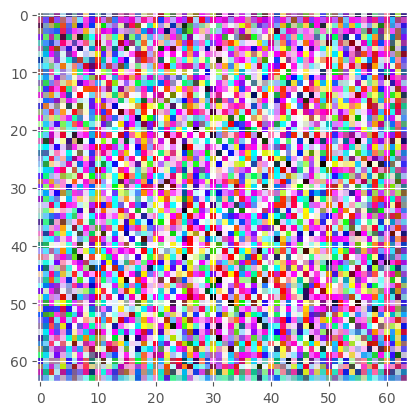

In [196]:
# show the output of model
y = G(torch.randn(2, CFG.nz))
print(y.shape)
single_image = denorm(y[0]).detach().numpy().transpose(1, 2, 0)

plt.imshow(single_image)

In [197]:
def reset_grad():
    optimizer_G.zero_grad()
    optimizer_D.zero_grad()
    ## reset gradient for optimizer of generator and discrimator

def train_discriminator(D_model, G_model, images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(images.shape[0], 1).to(device) # 
    fake_labels = torch.zeros(images.shape[0], 1).to(device)
    outputs = D_model(images)
    # Loss for real images
    real_score = outputs
    real_loss = criterion(real_score, real_labels)
    # Loss for fake images
    z = torch.randn(images.shape[0], CFG.nz).to(device)
    fake_images = G_model(z)
    outputs = D_model(fake_images)
    fake_score = outputs
    fake_loss = criterion(fake_score, fake_labels)
    # Sum losses
    d_loss = real_loss + fake_loss
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    optimizer_D.step()
    return d_loss, real_score, fake_score

def train_generator(G_model):
    z = np.random.normal(0, 1, (CFG.batch_size, CFG.nz))
    noise = 0.005*np.random.uniform()*np.amax(z)
    z = z.astype('float64') + noise*np.random.normal(size=z.shape)
    z = torch.Tensor(z).to(device)
    
    fake_images = G_model(z)
    fake_outputs = D(fake_images)
    labels = torch.ones(CFG.batch_size, 1).to(device)
    # calculate the generator loss
    g_loss = criterion(fake_outputs,labels)
    # Reset gradients
    reset_grad()
    # Backprop and optimize
    g_loss.backward()
    optimizer_G.step()
    return g_loss, fake_images

In [203]:
import torch

def load_checkpoint(checkpoint_path, G, D, optimizer_G, optimizer_D):
    checkpoint = torch.load(checkpoint_path)
    epoch = checkpoint['epoch']
    G.load_state_dict(checkpoint['generator_state_dict'])
    D.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer_G.load_state_dict(checkpoint['G_optimizer_state_dict'])
    optimizer_D.load_state_dict(checkpoint['D_optimizer_state_dict'])
    d_losses = checkpoint['d_losses']
    g_losses = checkpoint['g_losses']
    real_scores = checkpoint['real_scores']
    fake_scores = checkpoint['fake_scores']
    IS = checkpoint['IS']
    FID = checkpoint['FID']
    print(f"Checkpoint loaded from epoch {epoch}.")
    return epoch, d_losses, g_losses, real_scores, fake_scores, G, D, optimizer_G, optimizer_D, IS, FID

## Training process

In [199]:
sample_dir = "/home/jupyter/datasphere/project/Generative-Models-2024/Assignment 2/DCGAN/images"
def save_fake_images(index):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    z = np.random.normal(0, 1, (CFG.batch_size, CFG.nz))
    noise = 0.005*np.random.uniform()*np.amax(z)
    z = z.astype('float64') + noise*np.random.normal(size=z.shape)
    z = torch.Tensor(z).to(device)
    fake_images = G(z)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = 'fake_images-{0:0=3d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [204]:
device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

start_epoch, d_losses, g_losses, real_scores, fake_scores, G, D, optimizer_G, optimizer_D, IS_scores, FID_scores = load_checkpoint('/home/jupyter/datasphere/project/Generative-Models-2024/Assignment 2/DCGAN/checkpoint/checkpoint_11.pth', G, D, optimizer_G, optimizer_D)
G.to(device)
D.to(device)
total_step = len(dataloader)

# d_losses, g_losses, real_scores, fake_scores, IS_scores, FID_scores = [], [], [], [], [], []

Checkpoint loaded from epoch 10.


In [22]:
# clone is repo: https://github.com/w86763777/pytorch-gan-metrics.git and install pytorch-gan-metrics
!git clone https://github.com/w86763777/pytorch-gan-metrics.git

Cloning into 'pytorch-gan-metrics'...


In [23]:
%pip install pytorch-gan-metrics

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [192]:
%cd pytorch_gan_metrics

[Errno 2] No such file or directory: 'pytorch_gan_metrics'
/home/jupyter/work/resources/Generative-Models-2024/Assignment 2/pytorch_gan_metrics


In [201]:
# import pytorch_gan_metrics
from pytorch_gan_metrics.pytorch_image_generation_metrics import (get_inception_score,
                                 get_fid,
                                 get_inception_score_and_fid)

from torch.utils.data import Dataset

# create the Generator Dataset. returns the image, generated from the Generator network
class GeneratorDataset(Dataset):
    def __init__(self, G, z_dim):
        self.G = G
        self.z_dim = z_dim

    def __len__(self):
        return 500

    def __getitem__(self, index):
        return self.G(torch.randn(1, self.z_dim, 1, 1).cuda())[0]

# define dataset
#create dataloader
# G_eval = Genearator(CFG.nc, CFG.nz, CFG.ngf)
# G_eval.load_state_dict(torch.load('generator_v2.pth', map_location=CFG.device))

In [ ]:
%%time
# start_epoch = 0

# If a checkpoint exists, load it and resume training
# try:
#     start_epoch, d_losses, g_losses, real_scores, fake_scores = load_checkpoint(path+"checkpoint.pth", G, D, optimizer_G, optimizer_D)
# except FileNotFoundError:
#     print("No checkpoint found, starting training from scratch.")

num_epochs = 40

for epoch in range(start_epoch, num_epochs):
    for i, (images, _) in enumerate(dataloader):
        if i == 390:
            break
        # Load a batch & transform to vectors
        images = images.to(device)

        G.train()
        
        # Train the discriminator
        D.train()
        d_loss, real_score, fake_score = train_discriminator(D, G, images)

        # Train the generator
        G.train()
        g_loss, fake_images = train_generator(G)

        # Inspect the losses
        if (i + 1) % 130 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], '
                  f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, '
                  f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    # Sample and save images
    save_fake_images(epoch+1)
    if epoch % 5 == 0:
        G.eval()
        dataset = GeneratorDataset(G, CFG.nz)
        G_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
        # Inception Score
        # IS, _ = get_inception_score(G_dataloader)
        # print(f"Inception Score: {IS}")
        # # Frechet Inception Distance
        # FID = get_fid(G_dataloader, 'cifar10.train.npz')
        # print(f"FID: {FID}")
        (IS, IS_std), FID = get_inception_score_and_fid(G_dataloader, '/home/jupyter/datasphere/project/Generative-Models-2024/Assignment 2/cifar10.train.npz')
        IS_scores.append(IS)
        FID_scores.append(FID)
        print(f"Epoch [{epoch}/{num_epochs}], Inception Score: {IS}, FID: {FID}")
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': G.state_dict(),
            'discriminator_state_dict': D.state_dict(),
            'G_optimizer_state_dict': optimizer_G.state_dict(),
            'D_optimizer_state_dict': optimizer_D.state_dict(),
            'd_losses': d_losses,
            'g_losses': g_losses,
            'real_scores': real_scores,
            'fake_scores': fake_scores,
            'IS': IS_scores,
            'FID': FID_scores
        }
        torch.save(checkpoint, f"/home/jupyter/datasphere/project/Generative-Models-2024/Assignment 2/DCGAN/checkpoint/checkpoint_{epoch}.pth")


Epoch [10/40], Step [130/391], d_loss: 1.0536, g_loss: 1.8465, D(x): 0.56, D(G(z)): 0.30
Epoch [10/40], Step [260/391], d_loss: 1.6073, g_loss: 0.7612, D(x): 0.63, D(G(z)): 0.63
Epoch [10/40], Step [390/391], d_loss: 1.0209, g_loss: 1.8972, D(x): 0.65, D(G(z)): 0.39
Saving fake_images-011.png
Epoch [10/40], Inception Score: 3.8882337856333407, FID: 159.77560552322018
Epoch [11/40], Step [130/391], d_loss: 0.8878, g_loss: 2.1446, D(x): 0.79, D(G(z)): 0.44
Epoch [11/40], Step [260/391], d_loss: 1.0995, g_loss: 1.3719, D(x): 0.49, D(G(z)): 0.25
Epoch [11/40], Step [390/391], d_loss: 1.0927, g_loss: 3.0273, D(x): 0.82, D(G(z)): 0.56
Saving fake_images-012.png
Epoch [12/40], Step [130/391], d_loss: 1.3354, g_loss: 1.2527, D(x): 0.38, D(G(z)): 0.20
Epoch [12/40], Step [260/391], d_loss: 1.0454, g_loss: 2.0259, D(x): 0.65, D(G(z)): 0.40
Epoch [12/40], Step [390/391], d_loss: 1.1823, g_loss: 1.2505, D(x): 0.48, D(G(z)): 0.27
Saving fake_images-013.png
Epoch [13/40], Step [130/391], d_loss: 1.3

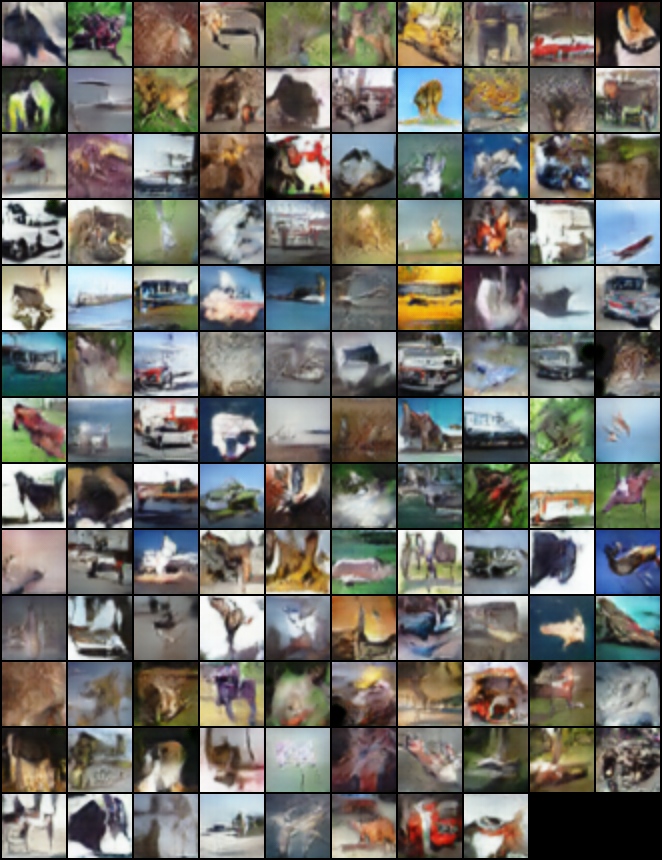

In [208]:
Image(os.path.join(sample_dir, 'fake_images-040.png'))

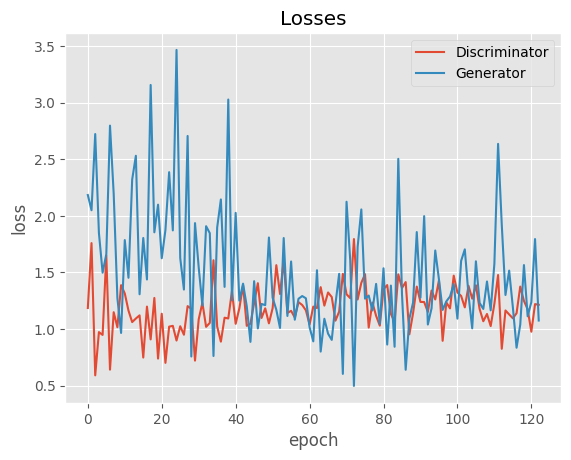

In [209]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

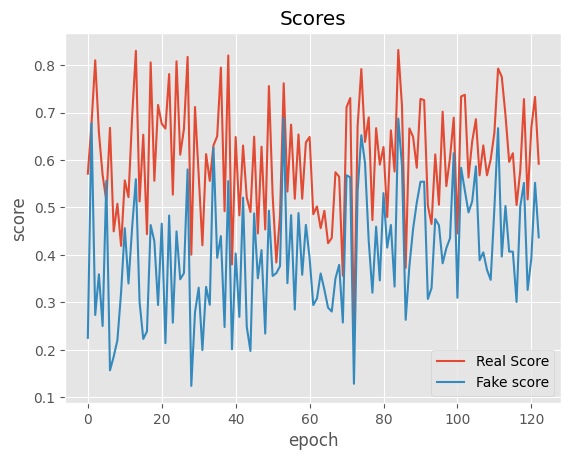

In [210]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [211]:
len(IS_scores)

9

In [212]:
G.eval()
dataset = GeneratorDataset(G, CFG.nz)
G_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
# Inception Score
# IS, _ = get_inception_score(G_dataloader)
# print(f"Inception Score: {IS}")
# # Frechet Inception Distance
# FID = get_fid(G_dataloader, 'cifar10.train.npz')
# print(f"FID: {FID}")
(IS, IS_std), FID = get_inception_score_and_fid(G_dataloader, '/home/jupyter/datasphere/project/Generative-Models-2024/Assignment 2/cifar10.train.npz')
IS_scores.append(IS)
FID_scores.append(FID)
print(f"Inception Score: {IS}, FID: {FID}")
checkpoint = {
    'epoch': 40,
    'generator_state_dict': G.state_dict(),
    'discriminator_state_dict': D.state_dict(),
    'G_optimizer_state_dict': optimizer_G.state_dict(),
    'D_optimizer_state_dict': optimizer_D.state_dict(),
    'd_losses': d_losses,
    'g_losses': g_losses,
    'real_scores': real_scores,
    'fake_scores': fake_scores,
    'IS': IS_scores,
    'FID': FID_scores
}
torch.save(checkpoint, f"/home/jupyter/datasphere/project/Generative-Models-2024/Assignment 2/DCGAN/checkpoint/checkpoint_40.pth")


Inception Score: 4.460062935459694, FID: 120.88351282275875


In [213]:
# Inception Score
IS, _ = get_inception_score(G_dataloader)
print(f"Inception Score: {IS}")

Inception Score: 4.163856001339981


In [216]:
# Frechet Inception Distance
FID = get_fid(G_dataloader, '/home/jupyter/datasphere/project/Generative-Models-2024/Assignment 2/cifar10.train.npz')
print(f"FID: {FID}")

FID: 123.75686541117159


In [217]:
(IS, IS_std), FID = get_inception_score_and_fid(
    G_dataloader, 
    '/home/jupyter/datasphere/project/Generative-Models-2024/Assignment 2/cifar10.train.npz'
)
print(f"Inception Score: {IS}\nFID: {FID}")

Inception Score: 4.336667238906425
FID: 120.44819589281366
